# Calibrate single camera

The aim of this calibration is to:
1. Assess the distortion of the cameras
2. function between X,Y,Z coordinates of the world and X,Y coordinates of the frame

## Plan
1. Open the video recorded with a camera
2. Detect corners of the chessboard
4. Calibrate and return points
5. Join the calibration info from previous steps and perform stereo calibration

In [1]:
import numpy as np
import cv2 as cv
import time
import matplotlib.pyplot as plt
from utils import DLT

## 1. Define function to calibrate single cameras

In [2]:
def calibrate_both_cameras(VideoNameA,VideoNameB):

    capA = cv.VideoCapture(VideoNameA)
    capB = cv.VideoCapture(VideoNameB)
    
    find_flags = cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE
    world_scaling = 30. #change this to the real world square size.

    # termination criteria
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 50, 0.001)
 
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*8,3), np.float32)
    objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)
    objp = world_scaling* objp
     
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpointsA = [] # 2d points in image plane.
    imgpointsB = [] # 2d points in image plane.

    counter = 1
    
    while(capA.isOpened()):
        retA, frameA = capA.read()
        retB, frameB = capB.read()
        counter = counter +1
        if retA == True and retB == True and np.mod(counter,4)==0:
            greyFrameA = cv.cvtColor(frameA, cv.COLOR_BGR2GRAY) 
            greyFrameB = cv.cvtColor(frameB, cv.COLOR_BGR2GRAY)
            
            # Find the chess board corners
            retA1, cornersA = cv.findChessboardCorners(greyFrameA, (8,6),flags = find_flags) 
            retB1, cornersB= cv.findChessboardCorners(greyFrameB, (8,6),flags = find_flags) 
            
            if retA1 == True and retB1 == True:
                objpoints.append(objp)
     
                corners2A = cv.cornerSubPix(greyFrameA,cornersA, (11,11), (-1,-1),criteria)
                corners2B = cv.cornerSubPix(greyFrameB,cornersB, (11,11), (-1,-1),criteria)
                imgpointsA.append(corners2A)
                imgpointsB.append(corners2B)
            
                # Draw and display the corners  just for one frame
                cv.drawChessboardCorners(frameA, (8,6), corners2A, retA1)
                cv.drawChessboardCorners(frameB, (8,6), corners2B, retB1)
                
                frame_cat = cv.hconcat([frameA,frameB])
                half = cv.resize(frame_cat, (0, 0), fx = 0.5, fy = 0.5)
                cv.imshow('Frame', half)
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
            
    capA.release()
    capB.release()
    cv.destroyAllWindows()
    ## Calibrate
    retA, mtxA, distA, rvecsA, tvecsA = cv.calibrateCamera(objpoints, imgpointsA, greyFrameA.shape[::-1], None, None)
    retB, mtxB, distB, rvecsB, tvecsB = cv.calibrateCamera(objpoints, imgpointsB, greyFrameB.shape[::-1], None, None)
    
    return objpoints,imgpointsA,greyFrameA, retA,mtxA,distA,imgpointsB,greyFrameB,retB,mtxB,distB

In [3]:
# Video name
Nvideo = '1'

#VideoA = '.\Calibration\Example_video_5a.avi'
#VideoB = '.\Calibration\Example_video_5b.avi'

VideoA = '.\Calibration\Calib_video_'+Nvideo+'A.avi'
VideoB = '.\Calibration\Calib_video_'+Nvideo+'B.avi'
print(VideoA)

.\Calibration\Calib_video_1A.avi


## 2. Detect corners of the chessboard

In [4]:
objpoints,imgpointsA,greyFrameA, retA,mtxA,distA,imgpointsB,greyFrameB, retB,mtxB,distB = calibrate_both_cameras(VideoA,VideoB)
len(imgpointsA)

25

In [5]:
stereocalibration_flags = cv.CALIB_FIX_INTRINSIC
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
ret3D, CM1, dist1, CM2, dist2, R, T, E, F = cv.stereoCalibrate(objpoints, imgpointsA, imgpointsB, mtxA, distA,
                                                                 mtxB, distB, greyFrameA.shape[::-1], criteria = criteria, flags = stereocalibration_flags)
 

In [6]:
print(retA)
print(retB)
print(ret3D)
#RT matrix for C1 is identity.
RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P1 = mtxA @ RT1 #projection matrix for C1
 
#RT matrix for C2 is the R and T obtained from stereo calibration.
RT2 = np.concatenate([R, T], axis = -1)
P2 = mtxB @ RT2 #projection matrix for C2
np.savez('.\Calibration\Calibration_parameters', ret3D=ret3D, CM1=CM1,dist1=dist1,CM2=CM2,dist2=dist2,R=R,T=T,E=E, F=F,P1 = P1, P2 = P2)

2.814360980045702
1.319458750665283
2.36574326558648


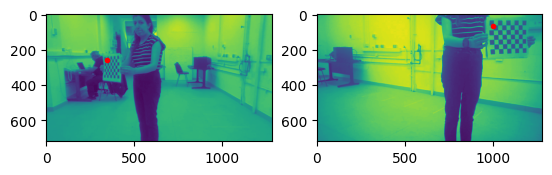

In [7]:
Nframes = len(imgpointsA)-1

## plot last frame and the first point detected there
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(greyFrameA)
ax1.plot(imgpointsA[Nframes][0][0][0],imgpointsA[Nframes][0][0][1],'.r')

ax2.imshow(greyFrameB)
ax2.plot(imgpointsB[Nframes][0][0][0],imgpointsB[Nframes][0][0][1],'.r')

#print(imgpointsA[Nframes][0][0])

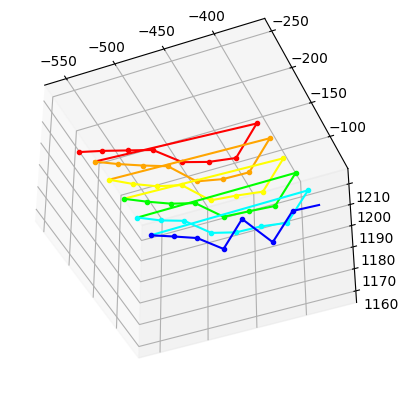

In [8]:
from mpl_toolkits.mplot3d import Axes3D
colours=['red','orange','yellow','lime','cyan','blue']



fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')

for iframes in np.arange(0,Nframes):
    D3Points=[]
    
    for i in np.arange(0,8*6):
        D3Point = DLT(P1,P2,imgpointsA[iframes][i][0], imgpointsB[iframes][i][0])
        D3Points.append(D3Point)
    if iframes == 0:
        Maxs=np.max(D3Points,0)+10
        Mins=np.min(D3Points,0)-10
    
    for i in np.arange(0,8*6-1): 
        row = int(np.floor(i/8))
        ax.plot(D3Points[i][0], D3Points[i][1],D3Points[i][2],'.',color = colours[row])
        ax.plot(xs=[D3Points[i][0],D3Points[i+1][0]], ys = [D3Points[i][1],D3Points[i+1][1]],zs = [D3Points[i][2],D3Points[i+1][2]],c = colours[row])
    
    
    ax.set_xlim3d([Mins[0], Maxs[0]])
    ax.set_ylim3d([Mins[1], Maxs[1]])
    ax.set_zlim3d([Mins[2], Maxs[2]])
    ax.view_init(-41, -67)    
    plt.show()
    plt.pause(0.01)
    figname='.\Calibration\Fig_'+str(iframes)+'.png'
    #plt.savefig(figname, bbox_inches='tight')
    ax.cla()



## Testing the calibration 